## Facial Key Point Detector

A CNN network is trained to detect 68 facial keypoints.
The architecture of CNN is based on [Naimish paper](https://arxiv.org/pdf/1710.00977.pdf). Other simpler ones could also work. 



## Loading the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2
from torchvision import transforms, utils
import torch.optim as optim




## Defining the network

Based on the referenced paper...


In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        #Model with input size of 96x96
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.conv4 = nn.Conv2d(128, 256, 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 5 * 5, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 136)
        
        self.dropoutconv1 = nn.Dropout(0.1)
        self.dropoutconv2 = nn.Dropout(0.2)
        self.dropoutconv3 = nn.Dropout(0.3)
        self.dropoutconv4 = nn.Dropout(0.4)
        self.dropoutfc1 = nn.Dropout(0.5)
        self.dropoutfc2 = nn.Dropout(0.6)
        
        
    def forward(self, x):
        x = self.dropoutconv1(self.pool(F.elu(self.conv1(x))))
        x = self.dropoutconv2(self.pool(F.elu(self.conv2(x))))
        x = self.dropoutconv3(self.pool(F.elu(self.conv3(x))))
        x = self.dropoutconv4(self.pool(F.elu(self.conv4(x))))
        
        #Model with input size of 96x96
        x = x.view(-1, 256 * 5 * 5)
        
        x = self.dropoutfc1(F.elu(self.fc1(x)))
        x = self.dropoutfc2((self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [3]:
net = Net()

cudaAvailable = torch.cuda.is_available()

if cudaAvailable:
    print("net is set to cuda!")
    net = net.cuda()

print(net)

net is set to cuda!
Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
  (dropoutconv1): Dropout(p=0.1, inplace=False)
  (dropoutconv2): Dropout(p=0.2, inplace=False)
  (dropoutconv3): Dropout(p=0.3, inplace=False)
  (dropoutconv4): Dropout(p=0.4, inplace=False)
  (dropoutfc1): Dropout(p=0.5, inplace=False)
  (dropoutfc2): Dropout(p=0.6, inplace=False)
)


## Transform the dataset 

Using Dataset class torch.utils.data.Dataset, we create a new class that can combine the data from the csv file that contains the keypoints information with the images that need to be passed through the CNN.

Also a series of transformation classes are define. 

In [4]:
# inherits from torch.utils.data.Dataset
# most important part is __getitem_ method that with the use of an index
# reads a line from the csv file and from that line finds and loads the image with the same name
# This is one of the easiest ways to combine data from two sources

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(
                                    self.root_dir,
                                    self.key_pts_frame.iloc[idx, 0]
                                 )
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
# tranforms
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, STD = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0
        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

The concerete transform objects need to be created separately and can be combined susing the transform.Compose

In [5]:
data_transform = transforms.Compose([Rescale(100),
                                     RandomCrop(96),
                                     Normalize(),
                                     ToTensor()])



Now, we can create the combined and transformed dataset... 

In [6]:
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of train images: ', len(transformed_dataset))

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

print('Number of test images: ', len(test_dataset))

# The dataset is iteratable
for i in range(2):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of train images:  3462
Number of test images:  770
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

DataLoader [reference](http://pytorch.org/docs/master/data.html).

We then create the train and test dataloaders.


In [7]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Model training

Not much difference between SmoothL1Loss or MSE, probably because no outlier issue.

In [8]:
criterion = nn.SmoothL1Loss() #Or MSELoss not much difference

optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [10]:
def train_net(n_epochs):

    net.train()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']
        
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            optimizer.zero_grad()
            
            if cudaAvailable:
                key_pts = key_pts.cuda()
                images  = images.cuda()
                
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training!')

In [11]:
n_epochs = 25

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0021134517937898634
Epoch: 1, Batch: 20, Avg. Loss: 0.0005052555948495865
Epoch: 1, Batch: 30, Avg. Loss: 0.0004104895256459713
Epoch: 1, Batch: 40, Avg. Loss: 0.00030438686721026895
Epoch: 1, Batch: 50, Avg. Loss: 0.0002889758236706257
Epoch: 1, Batch: 60, Avg. Loss: 0.00032286862283945083
Epoch: 1, Batch: 70, Avg. Loss: 0.00024704900197684767
Epoch: 1, Batch: 80, Avg. Loss: 0.00023288267105817795
Epoch: 1, Batch: 90, Avg. Loss: 0.0002664718870073557
Epoch: 1, Batch: 100, Avg. Loss: 0.00025212807022035124
Epoch: 1, Batch: 110, Avg. Loss: 0.0002942678723484278
Epoch: 1, Batch: 120, Avg. Loss: 0.0003005941044539213
Epoch: 1, Batch: 130, Avg. Loss: 0.00033129783533513546
Epoch: 1, Batch: 140, Avg. Loss: 0.0002765153534710407
Epoch: 1, Batch: 150, Avg. Loss: 0.00023972365260124207
Epoch: 1, Batch: 160, Avg. Loss: 0.00023178383987396955
Epoch: 1, Batch: 170, Avg. Loss: 0.00023436593264341353
Epoch: 1, Batch: 180, Avg. Loss: 0.00022747470811009408
Epoch: 1,

Epoch: 8, Batch: 30, Avg. Loss: 0.00015183997340500354
Epoch: 8, Batch: 40, Avg. Loss: 0.00015796445310115815
Epoch: 8, Batch: 50, Avg. Loss: 0.00015523870987817646
Epoch: 8, Batch: 60, Avg. Loss: 0.00012687510531395673
Epoch: 8, Batch: 70, Avg. Loss: 0.00014084762521088124
Epoch: 8, Batch: 80, Avg. Loss: 0.00012419012002646922
Epoch: 8, Batch: 90, Avg. Loss: 0.00013052988704293967
Epoch: 8, Batch: 100, Avg. Loss: 0.00015771873388439417
Epoch: 8, Batch: 110, Avg. Loss: 0.00014709085086360573
Epoch: 8, Batch: 120, Avg. Loss: 0.0001543485065922141
Epoch: 8, Batch: 130, Avg. Loss: 0.00013449488207697868
Epoch: 8, Batch: 140, Avg. Loss: 0.00012217509094625712
Epoch: 8, Batch: 150, Avg. Loss: 0.00015355978067964316
Epoch: 8, Batch: 160, Avg. Loss: 0.00012558296136558057
Epoch: 8, Batch: 170, Avg. Loss: 0.00016052957996726035
Epoch: 8, Batch: 180, Avg. Loss: 0.0001337552759796381
Epoch: 8, Batch: 190, Avg. Loss: 0.00016894781682640314
Epoch: 8, Batch: 200, Avg. Loss: 0.00012294883746653796
E

Epoch: 15, Batch: 30, Avg. Loss: 0.00016925968322902918
Epoch: 15, Batch: 40, Avg. Loss: 0.00011799728311598301
Epoch: 15, Batch: 50, Avg. Loss: 0.00013352157827466727
Epoch: 15, Batch: 60, Avg. Loss: 0.00014375543780624866
Epoch: 15, Batch: 70, Avg. Loss: 0.00011202204413712025
Epoch: 15, Batch: 80, Avg. Loss: 0.00010064349789172411
Epoch: 15, Batch: 90, Avg. Loss: 0.00012548504583537577
Epoch: 15, Batch: 100, Avg. Loss: 0.0001155017246492207
Epoch: 15, Batch: 110, Avg. Loss: 0.00015804492123425008
Epoch: 15, Batch: 120, Avg. Loss: 0.00013416018383577465
Epoch: 15, Batch: 130, Avg. Loss: 0.00011042333766818047
Epoch: 15, Batch: 140, Avg. Loss: 0.00010870627174153924
Epoch: 15, Batch: 150, Avg. Loss: 0.0001314291637390852
Epoch: 15, Batch: 160, Avg. Loss: 0.00011680348170921207
Epoch: 15, Batch: 170, Avg. Loss: 0.00015286423126235603
Epoch: 15, Batch: 180, Avg. Loss: 0.0001476347716525197
Epoch: 15, Batch: 190, Avg. Loss: 0.00011754965968430043
Epoch: 15, Batch: 200, Avg. Loss: 0.00011

Epoch: 22, Batch: 20, Avg. Loss: 0.00010005242936313153
Epoch: 22, Batch: 30, Avg. Loss: 0.00014602312678471208
Epoch: 22, Batch: 40, Avg. Loss: 0.00013216978404670954
Epoch: 22, Batch: 50, Avg. Loss: 0.00010503108333796263
Epoch: 22, Batch: 60, Avg. Loss: 0.00010879615508019924
Epoch: 22, Batch: 70, Avg. Loss: 0.0001102396734058857
Epoch: 22, Batch: 80, Avg. Loss: 7.78434812091291e-05
Epoch: 22, Batch: 90, Avg. Loss: 0.00010951860062777997
Epoch: 22, Batch: 100, Avg. Loss: 0.0001115293176844716
Epoch: 22, Batch: 110, Avg. Loss: 0.0001415346967987716
Epoch: 22, Batch: 120, Avg. Loss: 9.11786686629057e-05
Epoch: 22, Batch: 130, Avg. Loss: 9.634045651182532e-05
Epoch: 22, Batch: 140, Avg. Loss: 0.00011632167873904109
Epoch: 22, Batch: 150, Avg. Loss: 0.00010987713281065225
Epoch: 22, Batch: 160, Avg. Loss: 0.00010055636567994953
Epoch: 22, Batch: 170, Avg. Loss: 8.663606690242887e-05
Epoch: 22, Batch: 180, Avg. Loss: 0.00015660368837416171
Epoch: 22, Batch: 190, Avg. Loss: 0.000113610165

## Mode Evaluation

First define a function to untransform the keypoints from the normalized range to the real values

In [16]:
def visualize_output(test_images, test_outputs, batch_size=10):
    
    test_images  = test_images.cpu()
    test_outputs = test_outputs.cpu()
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        image = test_images[i].data   
        image = image.cpu().numpy()   
        image = np.transpose(image, (1, 2, 0))   

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100
        
        plt.imshow(image, cmap='gray')
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        plt.axis('off')

    plt.show()
    


Another functions takes a smaple from test dataset by iteration over one batch and then passes that throught the network...

In [22]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        if cudaAvailable:
            images  = images.cuda()
            
        # forward pass to get net output
        output_pts = net(images)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first batch_size of images
        if i == 0:
            return images, output_pts

Now, using the functions to take a smaple and run through the network...

In [23]:
test_images, test_outputs = net_sample_output()

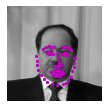

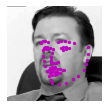

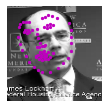

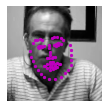

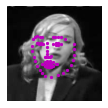

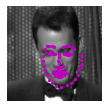

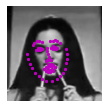

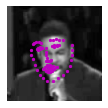

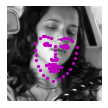

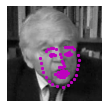

In [24]:
visualize_output(test_images, test_outputs)

Iterate over the test dataset with its dataloader and pass them to the network....

This approach generally tries to learn to predict a face feature and may be too biased for that!